In [7]:
import kagglehub
path = kagglehub.dataset_download("gpiosenka/sports-classification")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\ASUS\.cache\kagglehub\datasets\gpiosenka\sports-classification\versions\9


In [8]:
import os
import random
from PIL import Image
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision.transforms as T
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import math

# EDA

In [9]:
train_path = os.path.join(path, "train")
valid_path = os.path.join(path, "valid")
test_path = os.path.join(path, "test")

classes = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]
print("Class count: ", len(classes))
print("Classes: ", classes)

Class count:  100
Classes:  ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'rings

### Distribúcia tried

In [12]:
train_counts = {}
valid_counts = {}
test_counts = {}

for cls in classes:
    folder = os.path.join(train_path, cls)
    train_counts[cls] = len(os.listdir(folder))

    folder = os.path.join(valid_path, cls)
    valid_counts[cls] = len(os.listdir(folder))
    
    folder = os.path.join(test_path, cls)
    test_counts[cls] = len(os.listdir(folder))

temp_df = pd.DataFrame({
    "Class": classes,
    "Train": [train_counts[c] for c in classes],
    "Valid": [valid_counts[c] for c in classes],
    "Test":  [test_counts[c] for c in classes]
})
temp_df.style.set_table_attributes('style="display:inline-block; height:300px; overflow:auto;"')



In [113]:
def plot_cls_dist(classes, set):
    plt.figure(figsize=(25, 10))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xticks(rotation=90)
    plt.title(f"Distribúcia {set} setu obrázkov podľa tried")
    plt.xlabel("Trieda")
    plt.ylabel("Počet")
    plt.show()


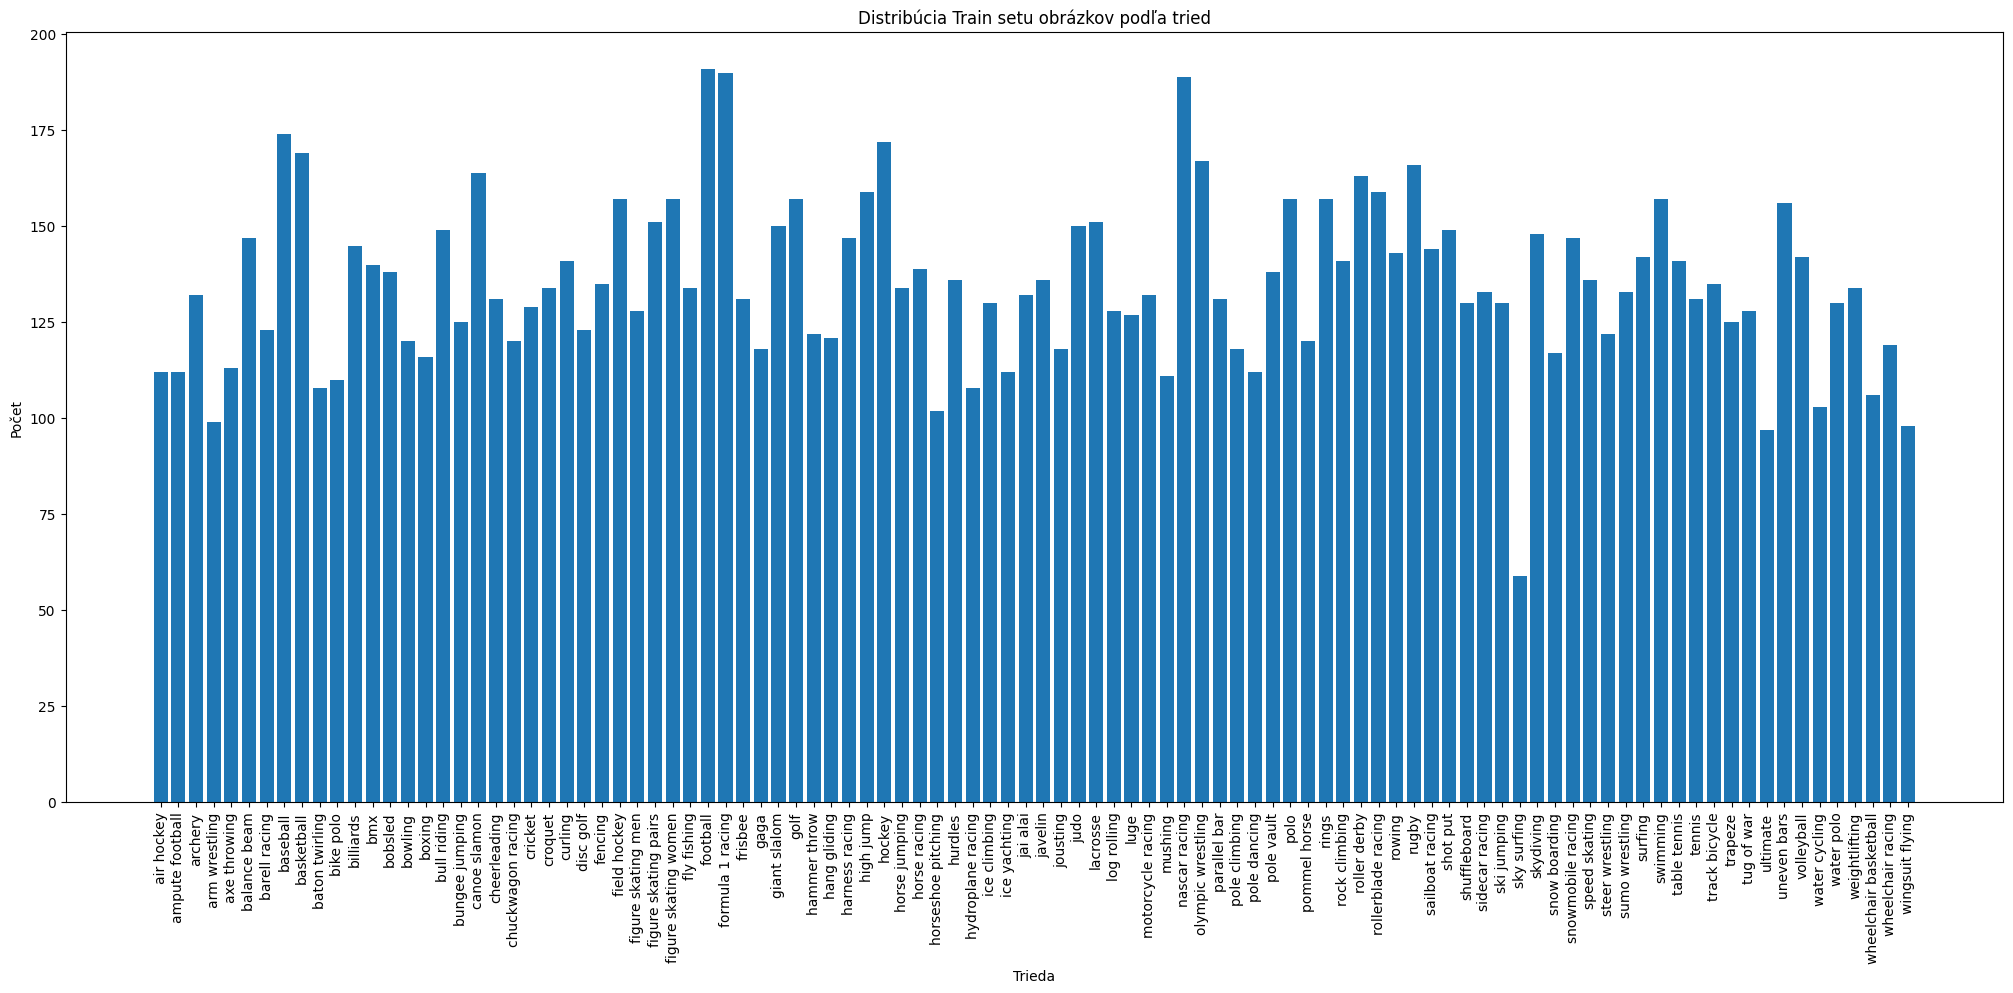

In [ ]:
plot_cls_dist(train_counts, "Train")

### Príklady obrázkov z datasetu

In [115]:
def display_img(how_many, classes, path):
    for i in range(how_many):
        random_class = random.choice(classes)
        random_image = random.choice(os.listdir(os.path.join(path, random_class)))

        img_path = os.path.join(path, random_class, random_image)
        img = Image.open(img_path)

        plt.imshow(img)
        plt.title(f"Trieda: {random_class}")
        plt.axis("off")
        plt.show()

def display_img_grid(classes, path):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        cls = random.choice(classes)
        file = random.choice(os.listdir(os.path.join(path, cls)))
        img = Image.open(os.path.join(path, cls, file))

        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

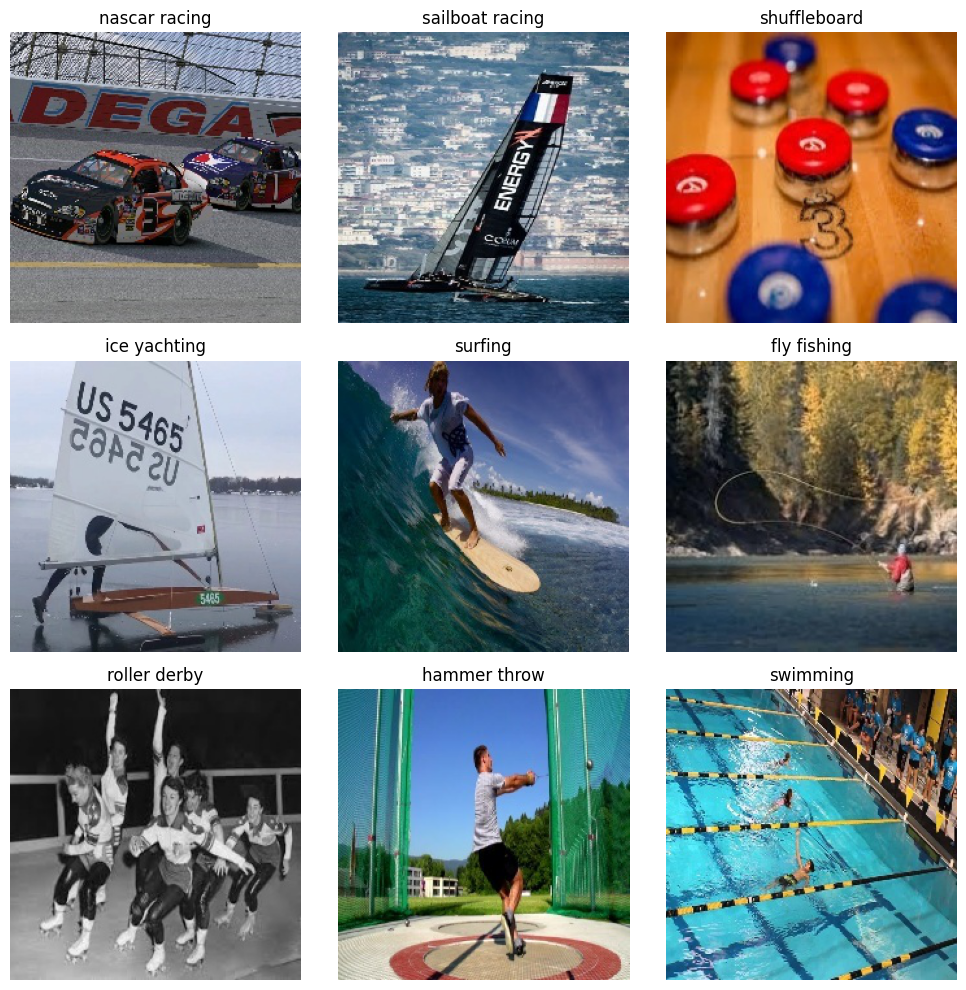

In [116]:
display_img_grid(classes, train_path)

### Veľkosti obrázkov

In [117]:
def analyze_size(classes, path):
    widths = []
    heights = []

    for cls in classes:
        folder = os.path.join(path, cls)
        
        for file in os.listdir(folder):
            img_path = os.path.join(folder, file)
            try:
                img = Image.open(img_path)
                w, h = img.size
                widths.append(w)
                heights.append(h)
            except:
                pass
    return widths, heights

def plot_sizes(widths, heights):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(widths, bins = 30)
    plt.title("Widths")

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=30)
    plt.title("Heights")

    plt.show()

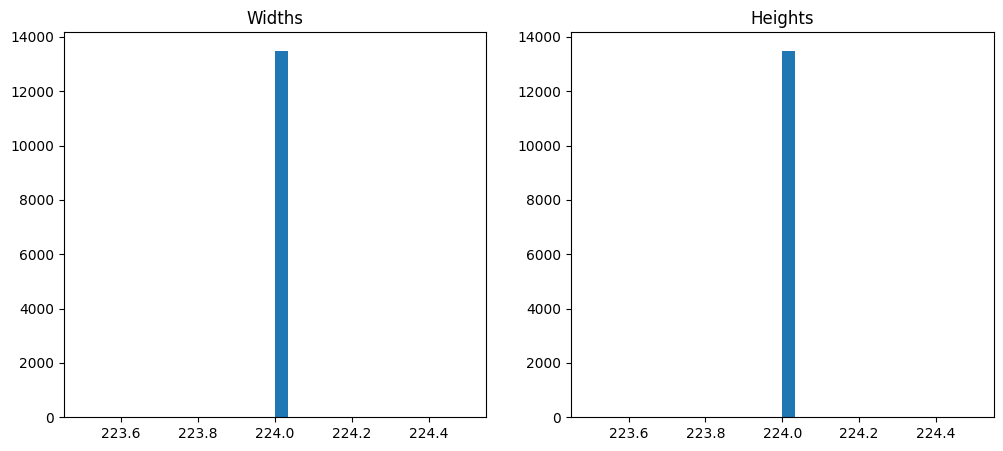

In [118]:
w, h = analyze_size(classes, train_path)
plot_sizes(w, h)

### Farebnosť

In [119]:
def analyze_colors(classes, path):
    color_modes = Counter()
    for cls in classes:
        folder = os.path.join(path, cls)

        for file in os.listdir(folder):
            img_path = os.path.join(folder, file)
            try:
                img = Image.open(img_path)
                color_modes[img.mode] += 1
            except:
                pass
    print(color_modes)

In [120]:
analyze_colors(classes, train_path)

Counter({'RGB': 13492})


### Formáty obrázkov

In [121]:
def check_image_formats(path):
    format_counts = defaultdict(int)

    for subdir, dirs, files in os.walk(path):
        for file in files:
            ext = os.path.splitext(file)[1].lower()

            if ext in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".tif", ".gif"]:
                format_counts[ext] += 1
    
    df = pd.DataFrame({
        "format": list(format_counts.keys()),
        "count": list(format_counts.values())
    }) 

    return df

In [122]:
formats = check_image_formats(train_path)
formats

format  count
0   .jpg  13492

In [123]:
def convert_img_to_rgb(path):
    converted = 0
    error_files = []

    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".tif", ".gif")):

                path = os.path.join(subdir, file)
                
                try:
                    img = Image.open(path)
                    if img.mode == "RGB":
                        continue
                    last = img
                    rgb_img = img.convert("RGB")
                    last_conv = rgb_img
                    rgb_img.save(path)
                    converted += 1
                except Exception as e:
                    error_files.append((path, str(e)))
    print(f"{converted} files converted")
    return last, last_conv

def before_after_show(before, after):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(before)
    plt.title("Before")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(after)
    plt.title("After")
    plt.axis("off")

    plt.show()

In [124]:
#before, after = convert_img_to_rgb(train_path)
#before_after_show(before, after)

In [125]:

augmentations = [
    A.Resize(224, 224),
    A.HorizontalFlip(p=1.0),
    A.Rotate(limit=10, p=1.0),
    A.RandomBrightnessContrast(p=1.0),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=1.0),
    A.GridDropout(ratio=0.5, unit_size_min=20, unit_size_max=50, p=1.0),
]


c:\Users\ASUS\anaconda3\envs\torch_gpu\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15396\509169035.py:7: UserWarning: Argument(s) 'unit_size_min, unit_size_max' are not valid for transform GridDropout
  A.GridDropout(ratio=0.5, unit_size_min=20, unit_size_max=50, p=1.0),


In [126]:
def display_augmentations(path):
    cls = random.choice(classes)
    img_file = random.choice(os.listdir(os.path.join(path, cls)))
    img_file = os.path.join(path, cls, img_file)

    img = Image.open(img_path)

    num_augs = len(augmentations)
    cols = min(3, num_augs + 1)
    rows = math.ceil((num_augs + 1) / cols)


    plt.figure(figsize=(cols*5, rows*5))

    plt.subplot(rows, cols, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    img_np = np.array(img)
    for i, aug in enumerate(augmentations):
        aug_compose = A.Compose([
                    aug, 
                    A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
                    ToTensorV2()])
        aug_img = aug_compose(image=img_np)["image"]
        aug_img = aug_img.permute(1, 2, 0).numpy()

        plt.subplot(rows, cols, i+2)
        plt.imshow(aug_img)
        plt.title(f"Aug {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.297952].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3959913].


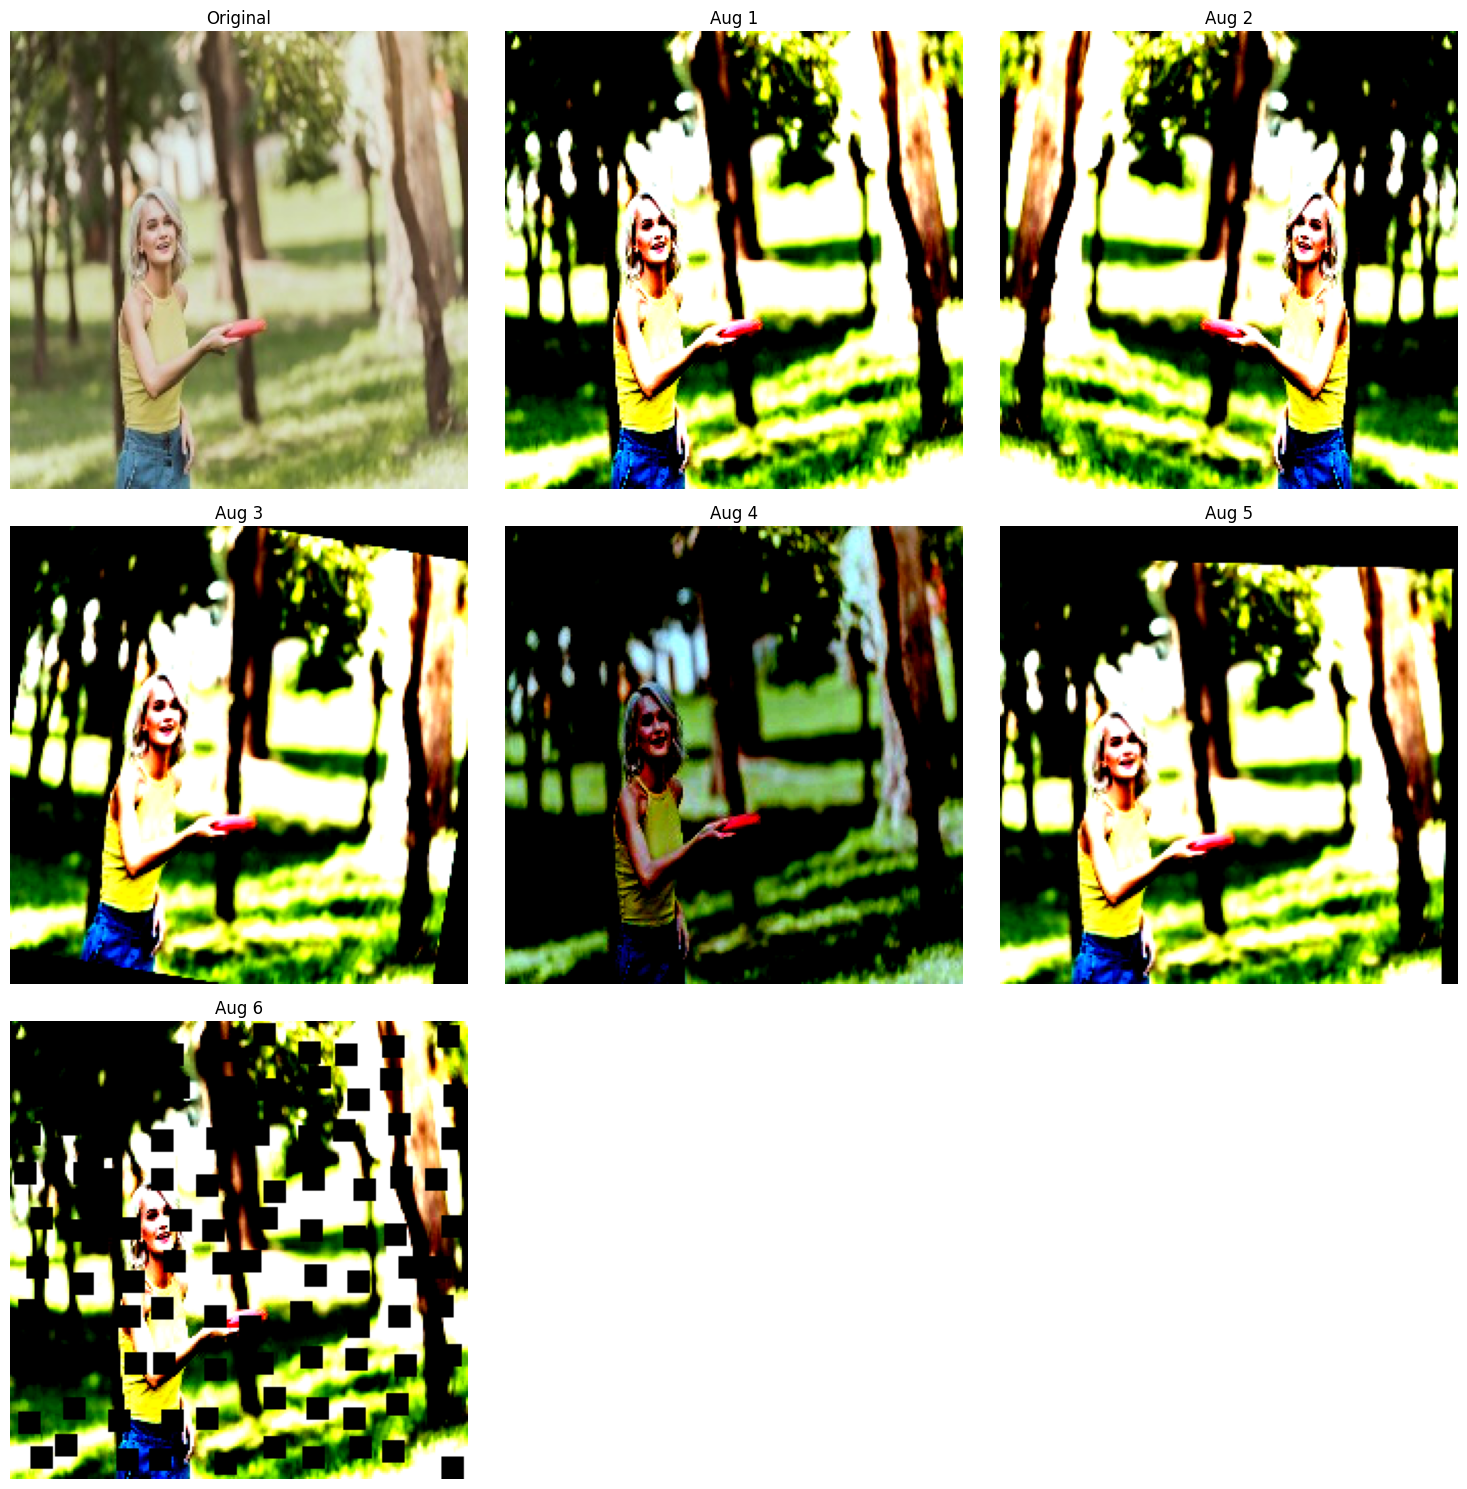

In [127]:
display_augmentations(train_path)